In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [19]:
# Initialisation de Spark
spark = SparkSession.builder.appName("NYC_Taxi_Trip_Analysis")  \
    .config("spark.master","spark://spark-master:7077")\
    .getOrCreate()

In [20]:
# Charger les données depuis HDFS (ou une autre source)
data_path = "hdfs://namenode:9000/user/data/yellow_tripdata.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [21]:
# Afficher les colonnes pour comprendre la structure des données
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [22]:
# Filtrer et sélectionner les colonnes utiles
df = df.select(
    "trip_distance",   # Distance du trajet
    "passenger_count", # Nombre de passagers
    "fare_amount",     # Montant payé
    "payment_type",    # Type de paiement (catégorique)
    "tip_amount",      # Pourboire (valeur cible)
)

In [23]:
# Supprimer les lignes avec des valeurs nulles
df = df.dropna()

In [24]:
# Encodage des variables catégoriques (ex. payment_type)
indexer = StringIndexer(inputCol="payment_type", outputCol="payment_type_index")
df = indexer.fit(df).transform(df)

In [25]:
# Assembleur pour créer un vecteur de features
assembler = VectorAssembler(
    inputCols=["trip_distance", "passenger_count", "fare_amount", "payment_type_index"],
    outputCol="features"
)
df = assembler.transform(df)

In [26]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [27]:
# Modèle de régression linéaire pour prédire le montant des pourboires
lr = LinearRegression(featuresCol="features", labelCol="tip_amount")
model = lr.fit(train_data)

In [28]:
# Évaluation sur l'ensemble de test
predictions = model.transform(test_data)

In [29]:
# Évaluation des performances du modèle
evaluator = RegressionEvaluator(
    labelCol="tip_amount", 
    predictionCol="prediction", 
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2523.8828367819565


In [30]:
# Résultats du modèle
predictions.select("trip_distance", "fare_amount", "tip_amount", "prediction").show(10)

+-------------+-----------+----------+-------------------+
|trip_distance|fare_amount|tip_amount|         prediction|
+-------------+-----------+----------+-------------------+
|          0.0|        0.0|       0.0|-3.3926137011545467|
|          0.0|        1.0|       0.0|-1.0528276418175586|
|          0.0|        2.5|       0.0|-3.1054571263109283|
|          0.0|        8.8|       0.0|  2.068024301094071|
|          0.0|       19.5|       0.0| 3.2970544414247573|
|          0.0|      -68.0|       0.0|-11.215342099363086|
|          0.0|      -52.0|       0.0| -9.377540020363929|
|          0.0|      -10.8|       0.0| -6.870123096340638|
|          0.0|       -3.0|       0.0|-3.7492711534290075|
|          0.0|       -2.5|       0.0|-1.4669164090607436|
+-------------+-----------+----------+-------------------+
only showing top 10 rows



In [31]:
# Évaluer R²
r2 = model.summary.r2
print(f"R² (Coefficient de détermination): {r2}")

# Évaluer MAE
mae = model.summary.meanAbsoluteError
print(f"Mean Absolute Error (MAE): {mae}")

# Recalculer RMSE pour confirmation
rmse = model.summary.rootMeanSquaredError
print(f"Root Mean Squared Error (RMSE): {rmse}")


R² (Coefficient de détermination): 0.4899901511144652
Mean Absolute Error (MAE): 0.7922655043675012
Root Mean Squared Error (RMSE): 1.706371567192428


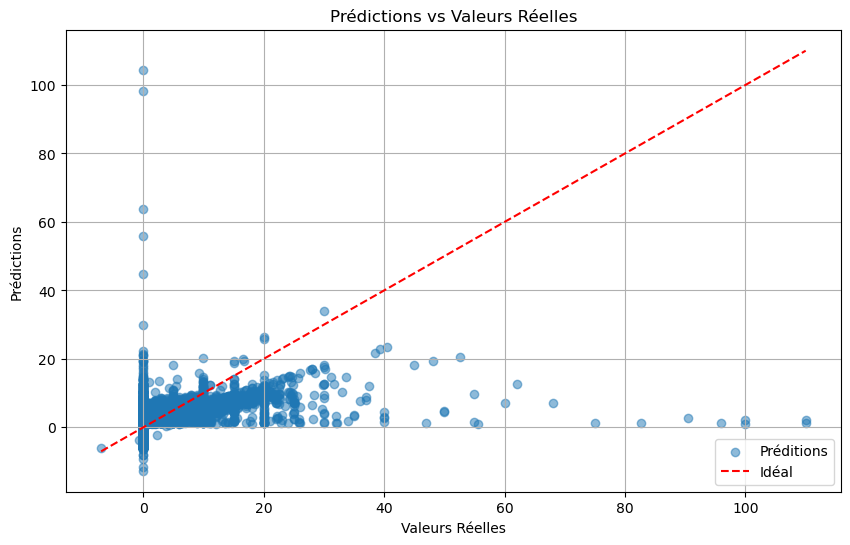

In [32]:
import matplotlib.pyplot as plt

# Collecter les données pour la visualisation
results = predictions.select("tip_amount", "prediction").sample(fraction=0.1).collect()

# Diviser les valeurs réelles et prédites
real_values = [row["tip_amount"] for row in results]
predicted_values = [row["prediction"] for row in results]

# Tracer les valeurs réelles vs prédites
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predicted_values, alpha=0.5, label="Préditions")
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color="red", linestyle="--", label="Idéal")
plt.title("Prédictions vs Valeurs Réelles")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Arrêter la session Spark
spark.stop()